## Forecasting Bike Sharing Usage
**Multiple Linear Regression, Subset Selection, Polynomial Regression**

In [96]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

import seaborn as sns


%matplotlib inline



## Data Exploration & Preprocessing, Multiple Linear Regression, Subset Selection


## Part 1: Data Read-In and Cleaning



**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that we name `bikes_df`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

In [97]:
bikes_df = pd.read_csv('C:\\Users\\shiva\\Desktop\\BSS_hour_raw.csv')

In [98]:
bikes_df.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1


In [99]:
bikes_df.describe()

,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


In [100]:
bikes_df.dtypes

dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object

#### **1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when we want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

The following is the conversion of **dteday** attribute into a datetime object:

In [101]:
# Casting bike dteday as Pandas datetime
bikes_df.dteday = pd.to_datetime(bikes_df.dteday, format='%Y-%m-%d')
bikes_df.dtypes

dteday        datetime64[ns]
season                 int64
hour                   int64
holiday                int64
weekday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
dtype: object

#### **1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that hour (this is the response variable for later).

In [102]:

bikes_df['year'] = bikes_df.dteday.dt.year - 2011
bikes_df['month'] = bikes_df['dteday'].dt.month
bikes_df['counts'] = bikes_df.casual + bikes_df.registered

In [103]:
# Check to ensure feature are correctly created
bikes_df.head()


,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,counts
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,0,1,16
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,0,1,40
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,0,1,32
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,0,1,13
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,0,1,1


## Part 2: Exploratory Data Analysis

 **2.1** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among all predictors in the dataset.  Note and comment on any strongly related variables. 

The following is the scatter plot of all of the features in the data model: 

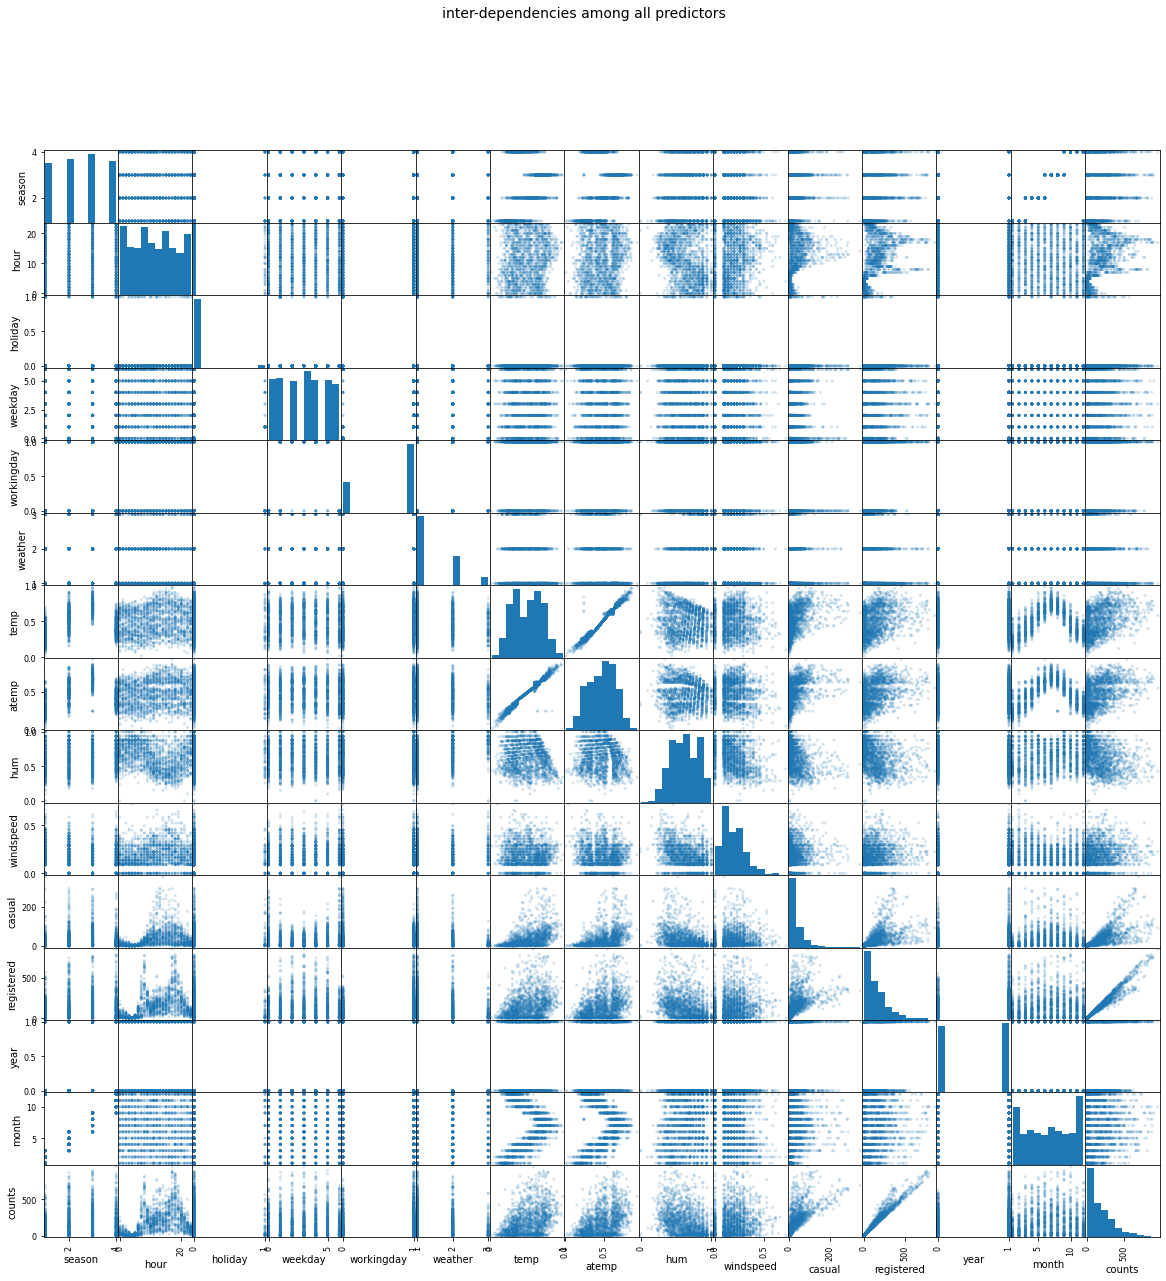

In [104]:
bikes_df_5 = bikes_df.sample(frac=0.1)
sc = pd.plotting.scatter_matrix(bikes_df_5, alpha=0.2, figsize=(20, 20))
plt.suptitle("inter-dependencies among all predictors", fontsize=14)
plt.show()


#### **2.2** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends we observe. 

The goal is of this study is to help predict the hourly demand for rental bikes. As a result, the data model must be summarized at the granularity of the hour as follows: 

In [105]:
hourly_bikes_df = bikes_df.groupby('hour').agg({
    'casual': np.mean,
    'registered': np.mean
})
hourly_bikes_df = hourly_bikes_df.round()
hourly_bikes_df.casual = hourly_bikes_df.casual.astype('int32')
hourly_bikes_df.registered = hourly_bikes_df.registered.astype('int32')
hourly_bikes_df.head()


,casual,registered
hour,,
0,10,44
1,7,27
2,5,18
3,3,9
4,1,5


The following figures show the average variation of the demand for rental bikes for a cycle of 24 hours in Washington DC from 2011 and 2012. 

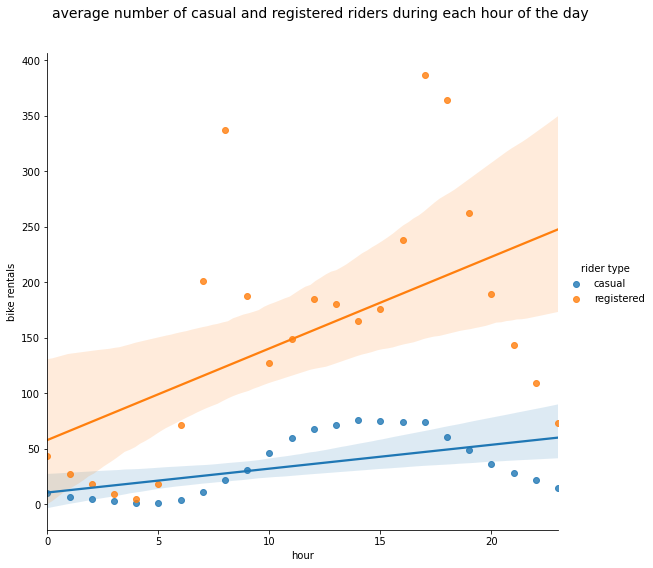

In [106]:
tidy_hourly_bikes_df = (
    hourly_bikes_df.stack() # pull the columns into row variables   
      .to_frame() # convert the resulting Series to a DataFrame
      .reset_index() # pull the resulting MultiIndex into the columns
      .rename(columns={0: 'bike rentals', 'level_1': 'rider type'}) # rename the unnamed column
)

lm = sns.lmplot(x = 'hour', y = 'bike rentals', hue = 'rider type', data = tidy_hourly_bikes_df, height = 8)

lm.fig.subplots_adjust(top=0.9)
a = lm.fig.suptitle("average number of casual and registered riders during each hour of the day", fontsize=14)

Even better than mere linear trends, the following figure tells the story of the customers, their habit, and their needs:


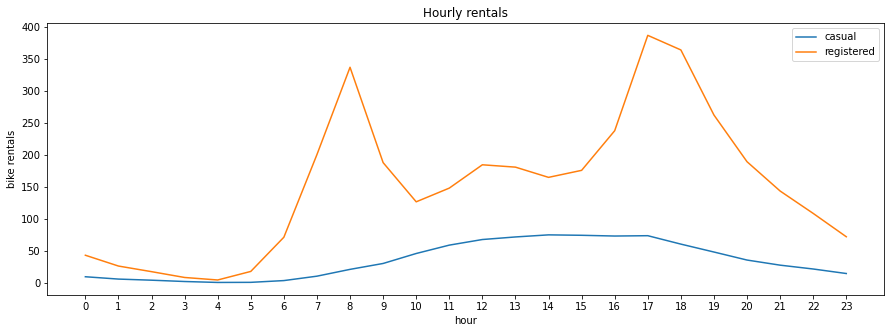

In [108]:

hourly_bikes_df = bikes_df.groupby('hour').agg({'casual': np.mean,'registered': np.mean})
def plot_casual_vs_registered(data):
    nb_plots = len(data)
    fig, ax = plt.subplots(1, nb_plots, figsize=(15,5))
    for i, d in enumerate(data):
        if nb_plots > 1:
            f = ax[i]
        else:
            f = ax
        f.set_xlabel('hour')
        f.set_ylabel('bike rentals')
        f.set_xticks(range(24))
        f.set_title(d['title'])
        d['frame'].plot(ax=f)
        

plot_casual_vs_registered([{'title':'Hourly rentals', 'frame': hourly_bikes_df}])
#plt.savefig('data/fig1.png', bbox_inches='tight')

#### **2.3** Use the variable `weather` to show how each weather category affects the relationships in question 2.2.  What do we observe?

In [109]:
# Summaring the data by hour and by weather as follows: 
weather_hourly_bikes_df = bikes_df.groupby(['hour', 'weather']).agg({
    'casual': np.mean,
    'registered': np.mean
})
weather_hourly_bikes_df = weather_hourly_bikes_df.round()
weather_hourly_bikes_df.casual = weather_hourly_bikes_df.casual.astype('int32')
weather_hourly_bikes_df.registered = weather_hourly_bikes_df.registered.astype('int32')
weather_hourly_bikes_df.head()

casual  registered
hour weather                    
0    1            11          48
     2             9          39
     3             4          25
1    1             7          27
     2             7          29

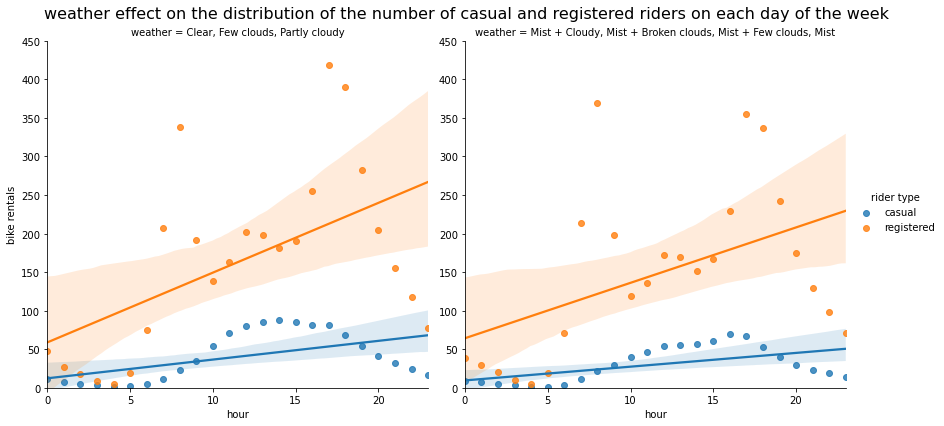

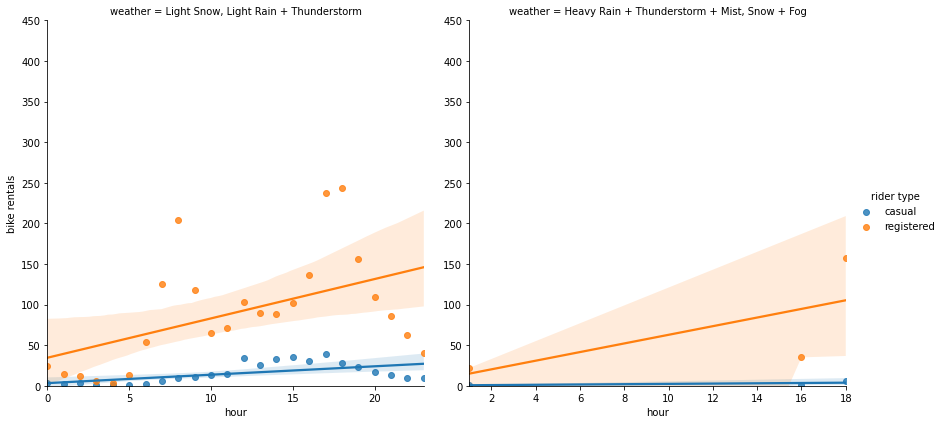

In [110]:
# Computing the graphs
tidy_weather_hourly_bikes_df = (
    weather_hourly_bikes_df.stack() # pull the columns into row variables   
      .to_frame() # convert the resulting Series to a DataFrame
      .reset_index() # pull the resulting MultiIndex into the columns
      .rename(columns={0: 'bike rentals', 'level_2': 'rider type', 'weather': 'weather_code'}) # rename the unnamed column
)
tidy_weather_hourly_bikes_df['weather'] = tidy_weather_hourly_bikes_df.weather_code
tidy_weather_hourly_bikes_df.weather = tidy_weather_hourly_bikes_df.weather.replace(1, 'Clear, Few clouds, Partly cloudy')
tidy_weather_hourly_bikes_df.weather = tidy_weather_hourly_bikes_df.weather.replace(2, 'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist')
tidy_weather_hourly_bikes_df.weather = tidy_weather_hourly_bikes_df.weather.replace(3, 'Light Snow, Light Rain + Thunderstorm')
tidy_weather_hourly_bikes_df.weather = tidy_weather_hourly_bikes_df.weather.replace(4, 'Heavy Rain + Thunderstorm + Mist, Snow + Fog')

tidy_weather_hourly_bikes_df
g = sns.lmplot(x = 'hour', y = 'bike rentals', hue = 'rider type', col = 'weather', 
           data = tidy_weather_hourly_bikes_df[((tidy_weather_hourly_bikes_df.weather_code==1) | 
                                               (tidy_weather_hourly_bikes_df.weather_code==2))], 
           height = 6, sharex=False, sharey=False)
g.set(ylim=(0, 450))
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('weather effect on the distribution of the number of casual and registered riders on each day of the week', fontsize=16)
g = sns.lmplot(x = 'hour', y = 'bike rentals', hue = 'rider type', col = 'weather', 
           data = tidy_weather_hourly_bikes_df[((tidy_weather_hourly_bikes_df.weather_code==3) | 
                                               (tidy_weather_hourly_bikes_df.weather_code==4))], 
           height = 6, sharex=False, sharey=False)
g.set(ylim=(0, 450))

#### **2.4** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature (normalized)
- `atemp`, the average atemp that day (normalized)
- `windspeed`, the average windspeed that day (normalized)
- `hum`, the average humidity that day (normalized)
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

#### Name this dataframe `bikes_by_day`.

#### Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

In [112]:
bikes_by_day = bikes_df.groupby(['dteday']).agg({
        'weekday': np.max,
        'weather': np.max,
        'season': np.max,
        'temp': np.mean,
        'atemp': np.mean,
        'windspeed': np.mean,
        'hum': np.mean,
        'casual': np.sum,
        'registered': np.sum,
    }).reset_index()


bikes_by_day.dteday = bikes_by_day.dteday.astype(str) + " 12:00"
bikes_by_day.dteday = pd.to_datetime(bikes_by_day.dteday, format='%Y-%m-%d %H:%M')
bikes_by_day['weekday'] = bikes_by_day.dteday.dt.weekday
bikes_by_day['counts'] = bikes_by_day.casual + bikes_by_day.registered

In [113]:
bikes_by_weekday = bikes_by_day.groupby(['weekday']).agg({
    'casual': np.sum,
    'registered': np.sum
})


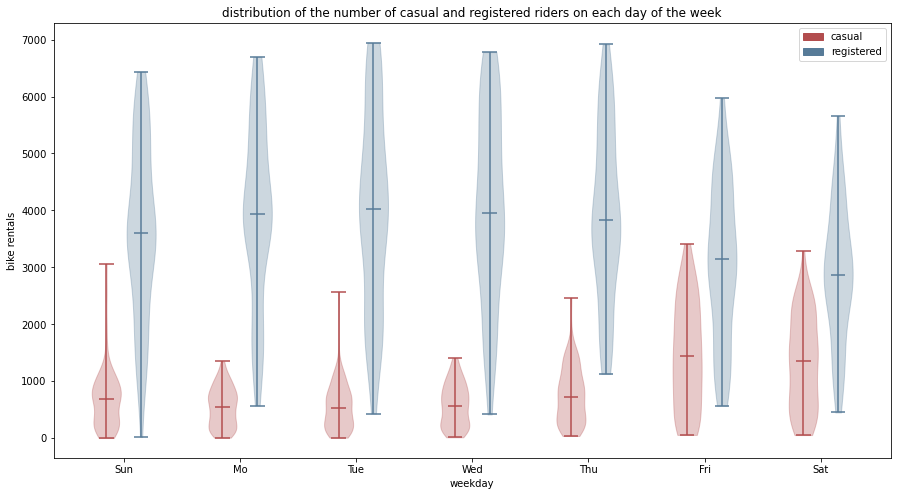

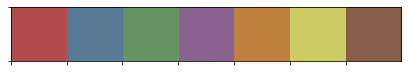

In [114]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(1, 1, figsize=(15,8))
weekdays = [0, 1, 2, 3, 4, 5, 6]
rider_types = ['casual', 'registered']
positions_array = np.arange(len(weekdays))
colors = sns.color_palette("Set1", n_colors=len(weekdays), desat=.5)
sns.palplot(colors)
fake_handles = []

for i, rider_type in enumerate(rider_types):
    offset = .15 * (-1 if i == 0 else 1)
    violin = ax.violinplot([
        bikes_by_day[bikes_by_day['weekday'] == wd][rider_type].values
        for wd in weekdays
    ], positions=positions_array + offset, widths=.25, showmedians=True, showextrema=True)

    # Set the color
    color = colors[i]
    for part_name, part in violin.items():
        if part_name == 'bodies':
            for body in violin['bodies']:
                body.set_color(color)
        else:
            part.set_color(color)
    fake_handles.append(mpatches.Patch(color=color))

ax.legend(fake_handles, rider_types)
ax.set_xticks(positions_array, weekdays)
ax.set_xticklabels(['', 'Sun', 'Mo', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax.set_xlabel("weekday")
ax.set_ylabel("bike rentals");
ax.set_title('distribution of the number of casual and registered riders on each day of the week');

#### **2.5** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do we see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If we see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) will help). 

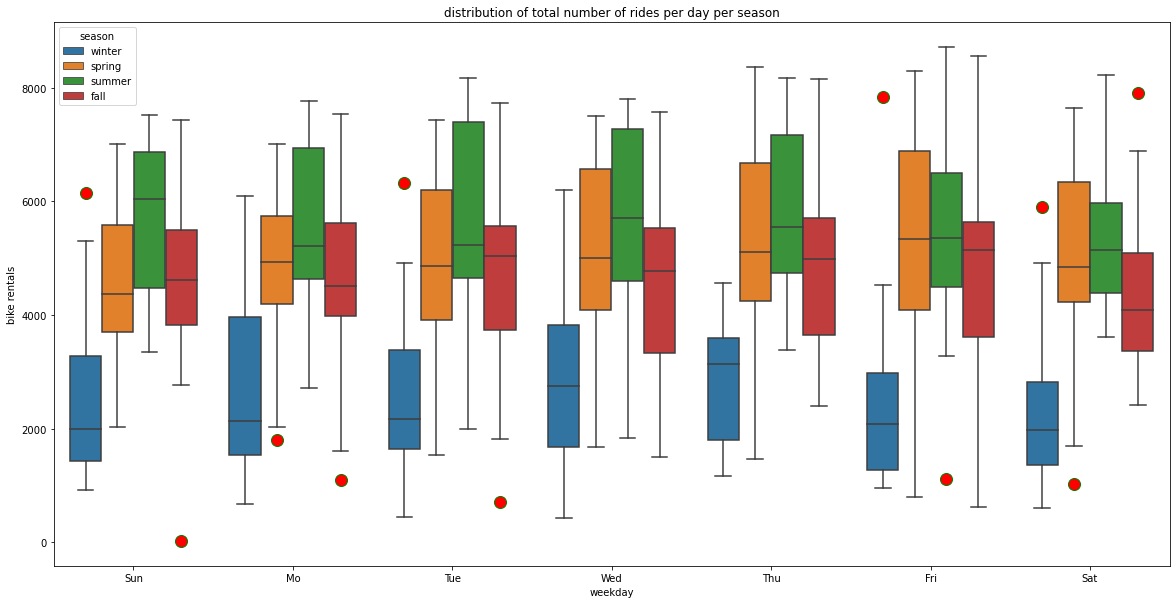

In [115]:
bikes_by_day.season = bikes_by_day.season.replace(1, 'winter').replace(2, 'spring').replace(3, 'summer').replace(4, 'fall')
fig, ax = plt.subplots(figsize=(20,10))
flierprops = dict(marker='o', markerfacecolor='r', markersize=12,
                  linestyle='none', markeredgecolor='g')
sns.boxplot(x="weekday", y="counts", hue="season", data=bikes_by_day, flierprops=flierprops, ax=ax)
ax.set_title('distribution of total number of rides per day per season')
ax.set_xticklabels(['Sun', 'Mo', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax.set_ylabel('bike rentals')
plt.show()


**Explanation about the outliers**

The following outliers are found by visual inspection of the boxplot above.

In [116]:
# the code here
outlier1 = bikes_by_day.loc[(bikes_by_day.weekday==0) & (bikes_by_day.season=='winter') & (bikes_by_day.counts>6000)]
outlier2 = bikes_by_day.loc[(bikes_by_day.weekday==0) & (bikes_by_day.season=='fall') & (bikes_by_day.counts<100)]
outlier3 = bikes_by_day.loc[(bikes_by_day.weekday==1) & (bikes_by_day.season=='spring') & (bikes_by_day.counts<2000)]
outlier4 = bikes_by_day.loc[(bikes_by_day.weekday==1) & (bikes_by_day.season=='fall') & (bikes_by_day.counts<1100)]
outlier5 = bikes_by_day.loc[(bikes_by_day.weekday==2) & (bikes_by_day.season=='winter') & (bikes_by_day.counts>6000)]
outlier6 = bikes_by_day.loc[(bikes_by_day.weekday==2) & (bikes_by_day.season=='fall') & (bikes_by_day.counts<1000)]
outlier7 = bikes_by_day.loc[(bikes_by_day.weekday==5) & (bikes_by_day.season=='winter') & (bikes_by_day.counts>6000)]
outlier8 = bikes_by_day.loc[(bikes_by_day.weekday==5) & (bikes_by_day.season=='summer') & (bikes_by_day.counts<2000)]
outlier9 = bikes_by_day.loc[(bikes_by_day.weekday==6) & (bikes_by_day.season=='winter') & (bikes_by_day.counts>5000)]
outlier10 = bikes_by_day.loc[(bikes_by_day.weekday==6) & (bikes_by_day.season=='spring') & (bikes_by_day.counts<1500)]
outlier11 = bikes_by_day.loc[(bikes_by_day.weekday==6) & (bikes_by_day.season=='fall') & (bikes_by_day.counts>6500)]
outlier1.append(outlier2).append(outlier3).append(outlier4).append(outlier5).append(outlier6).append(outlier7).append(outlier8).append(outlier9).append(outlier10).append(outlier11).sort_values(by=['dteday'])


,dteday,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,counts
94,2011-04-05 12:00:00,1,3,spring,0.414167,0.398350,0.388067,0.642083,167,1628,1795
238,2011-08-27 12:00:00,5,3,summer,0.680000,0.635556,0.375617,0.850000,226,889,1115
340,2011-12-07 12:00:00,2,3,fall,0.410000,0.400246,0.266175,0.970417,50,655,705
438,2012-03-14 12:00:00,2,2,winter,0.572500,0.548617,0.115063,0.507083,997,5315,6312
441,2012-03-17 12:00:00,5,2,winter,0.514167,0.505046,0.110704,0.755833,3155,4681,7836
442,2012-03-18 12:00:00,6,3,winter,0.472500,0.464000,0.126883,0.810000,2207,3685,5892
443,2012-03-19 12:00:00,0,2,winter,0.545000,0.532821,0.162317,0.728750,982,5171,6153
477,2012-04-22 12:00:00,6,3,spring,0.396667,0.389504,0.344546,0.835417,120,907,1027
631,2012-09-23 12:00:00,6,2,fall,0.529167,0.518933,0.223258,0.467083,2454,5453,7907
638,2012-09-30 12:00:00,6,3,fall,0.526667,0.517663,0.134958,0.583333,2015,4874,6889


**Investigation of the outliers**

An online search finds 2012-11-11 as to be the Veterans Day. Probably many of veterans checkout bikes for driving through Washington DC. This would explain the unexpected high count of bikes rental.

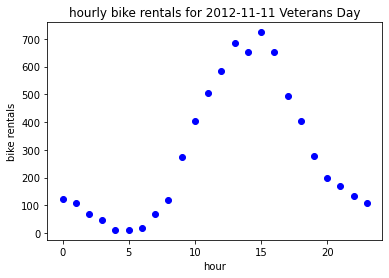

In [117]:
plt.scatter(range(24),bikes_df[bikes_df.dteday == '2012-11-11'].counts, label='2012-11-11', color='b')
plt.title('hourly bike rentals for 2012-11-11 Veterans Day')
plt.xlabel('hour')
plt.ylabel('bike rentals');

**Weather conditions and the occurence of outliers**

The weather on 2012-04-22 in Washington DC (Thunderstorm) probably explains the sudden drop in bike rentals.

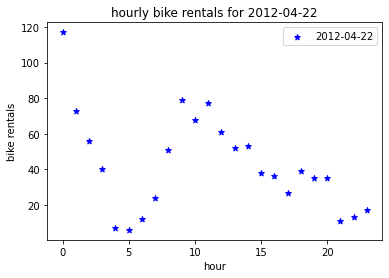

In [118]:
plt.scatter(range(24),bikes_df[bikes_df.dteday == '2012-04-22'].counts, label='2012-04-22', color='b', marker='*')
plt.title('hourly bike rentals for 2012-04-22')
plt.xlabel('hour')
plt.ylabel('bike rentals')
plt.legend()

**Duplicated data and outliers**

The plot of hourly bike rentals on the remaining dates shows a strong correlation to the data from 2012-11-11, this indicates a measurement abnormality.

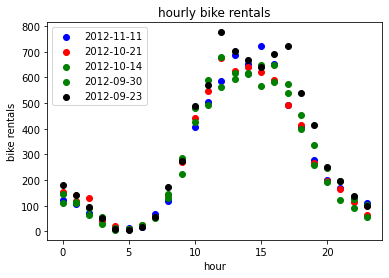

In [119]:
plt.scatter(range(24),bikes_df[bikes_df.dteday == '2012-11-11'].counts, label='2012-11-11', color='b')
plt.scatter(range(24),bikes_df[bikes_df.dteday == '2012-10-21'].counts, label='2012-10-21', color='r')
plt.scatter(range(24),bikes_df[bikes_df.dteday == '2012-10-14'].counts, label='2012-10-14', color='g')
plt.scatter(range(24),bikes_df[bikes_df.dteday == '2012-09-30'].counts, label='2012-09-30', color='g')
plt.scatter(range(24),bikes_df[bikes_df.dteday == '2012-09-23'].counts, label='2012-09-23', color='black')
plt.title('hourly bike rentals')
plt.xlabel('hour')
plt.ylabel('bike rentals')
plt.legend();



The data for 2012-10-30 and 201-10-29 show records missing for some bunch of hours, indicating a measurement abnormality. 

In [121]:
bikes_df[(bikes_df.dteday == '2012-10-30') | (bikes_df.dteday == '2012-10-29')]

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,counts
15883,2012-10-29,4,0,0,1,1,3,0.44,0.4394,0.88,0.3582,2,20,1,10,22
15884,2012-10-30,4,13,0,2,1,3,0.30,0.2727,0.81,0.3582,11,105,1,10,116
15885,2012-10-30,4,14,0,2,1,3,0.30,0.2727,0.81,0.3582,8,118,1,10,126
15886,2012-10-30,4,15,0,2,1,3,0.30,0.2879,0.87,0.2537,10,114,1,10,124
15887,2012-10-30,4,16,0,2,1,3,0.30,0.2879,0.87,0.2537,15,83,1,10,98
15888,2012-10-30,4,17,0,2,1,3,0.30,0.2879,0.87,0.2239,19,105,1,10,124
15889,2012-10-30,4,18,0,2,1,3,0.30,0.3030,0.87,0.1343,4,139,1,10,143
15890,2012-10-30,4,19,0,2,1,2,0.50,0.4848,0.68,0.1940,6,109,1,10,115
15891,2012-10-30,4,20,0,2,1,2,0.30,0.2879,0.81,0.1940,5,76,1,10,81
15892,2012-10-30,4,21,0,2,1,2,0.30,0.3182,0.87,0.1045,4,60,1,10,64


## Part 3: Prepare the data for Regression



#### **3.1** Using `bikes_df`, with hourly data about rentals, convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding**.

In [122]:
bikes_df_encoded = pd.get_dummies(bikes_df, columns=['season', 'month', 'weekday', 'weather'], drop_first=True)

In [123]:
bikes_df_encoded = bikes_df_encoded.rename(columns={'season_2':'spring', 'season_3':'summer', 'season_4':'fall', 
                                                    'month_2':'February', 'month_3':'March', 'month_4':'April', 'month_5':'May', 'month_6':'June', 'month_7':'July', 'month_8':'August', 'month_9':'September', 'month_10':'October', 'month_11':'November', 'month_12':'December',
                                                    'weekday_1':'Mon', 'weekday_2':'Tue','weekday_3':'Wed', 'weekday_4':'Thu','weekday_5':'Fri', 'weekday_6':'Sat'})

In [124]:
bikes_df_encoded.head()

,dteday,hour,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,December,Mon,Tue,Wed,Thu,Fri,Sat,weather_2,weather_3,weather_4
0,2011-01-01,0,0,0,0.24,0.2879,0.81,0.0,3,13,...,0,0,0,0,0,0,1,0,0,0
1,2011-01-01,1,0,0,0.22,0.2727,0.80,0.0,8,32,...,0,0,0,0,0,0,1,0,0,0
2,2011-01-01,2,0,0,0.22,0.2727,0.80,0.0,5,27,...,0,0,0,0,0,0,1,0,0,0
3,2011-01-01,3,0,0,0.24,0.2879,0.75,0.0,3,10,...,0,0,0,0,0,0,1,0,0,0
4,2011-01-01,4,0,0,0.24,0.2879,0.75,0.0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [125]:
bikes_df_encoded.columns

Index(['dteday', 'hour', 'holiday', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'casual', 'registered', 'year', 'counts', 'spring',
       'summer', 'fall', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December', 'Mon', 'Tue',
       'Wed', 'Thu', 'Fri', 'Sat', 'weather_2', 'weather_3', 'weather_4'],
      dtype='object')

####  **3.2** Split the updated `bikes_df` dataset in a train and test part. Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Explain the choice for a splitting algorithm.

In [126]:
months_list = ['year', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
try:
    # Stratify doesn't work if a value is missing
    train_data, test_data = train_test_split(bikes_df_encoded, test_size = 0.2, stratify=bikes_df_encoded[months_list])
except:
    # Drop missing lines
    print("Lines with missing values dropped")
    bikes_df_encoded = bikes_df_encoded.dropna(subset=months_list)
    train_data, test_data = train_test_split(bikes_df_encoded, test_size = 0.2, stratify=bikes_df_encoded[months_list])

In [127]:
# test data - monthly distribution after stratification
test_data_monthly_count = test_data.groupby(months_list).aggregate(['count'])['hour']
print("Mean: ", np.mean(test_data_monthly_count), "standard deviation: ", np.std(test_data_monthly_count))
# percentage of test data over each month
test_data_monthly_count/test_data.shape[0]

Mean:  count    144.833333
dtype: float64 standard deviation:  count    4.588633
dtype: float64


count
year February March April May June July August September October November December          
0    0        0     0     0   0    0    0      0         0       0        0         0.039413
                                                                          1         0.042578
                                                                 1        0         0.041427
                                                         1       0        0         0.042865
                                               1         0       0        0         0.041139
                                        1      0         0       0        0         0.042002
                                   1    0      0         0       0        0         0.042865
                              1    0    0      0         0       0        0         0.041427
                          1   0    0    0      0         0       0        0         0.042865
                    1     0   0    0    0      0         0       0        0         0.041427
              1     0     0   0    0    0      0         0       0        0         0.042002
     1        0     0     0   0    0    0      0         0       0        0         0.037399
1    0        0     0     0   0    0    0      0         0       0        0         0.042578
                                                                          1         0.042578
                                                                 1        0         0.041427
                                                         1       0        0         0.040564
                                               1         0       0        0         0.041427
                                        1      0         0       0        0         0.042865
                                   1    0      0         0       0        0         0.042865
                              1    0    0      0         0       0        0         0.041427
                          1   0    0    0      0         0       0        0         0.042865
                    1     0   0    0    0      0         0       0        0         0.041427
              1     0     0   0    0    0      0         0       0        0         0.042865
     1        0     0     0   0    0    0      0         0       0        0         0.039701

In [128]:
# train data - monthly distribution after stratification
train_data_monthly_count = train_data.groupby(months_list).aggregate(['count'])['hour']
print("Mean: ", np.mean(train_data_monthly_count), "standard deviation: ", np.std(train_data_monthly_count))
# percentage of train data over each month
train_data_monthly_count/train_data.shape[0]

Mean:  count    579.291667
dtype: float64 standard deviation:  count    17.903629
dtype: float64


count
year February March April May June July August September October November December          
0    0        0     0     0   0    0    0      0         0       0        0         0.039632
                                                                          1         0.042653
                                                                 1        0         0.041358
                                                         1       0        0         0.042725
                                               1         0       0        0         0.041286
                                        1      0         0       0        0         0.042077
                                   1    0      0         0       0        0         0.042797
                              1    0    0      0         0       0        0         0.041430
                          1   0    0    0      0         0       0        0         0.042797
                    1     0   0    0    0      0         0       0        0         0.041358
              1     0     0   0    0    0      0         0       0        0         0.042005
     1        0     0     0   0    0    0      0         0       0        0         0.037330
1    0        0     0     0   0    0    0      0         0       0        0         0.042653
                                                                          1         0.042725
                                                                 1        0         0.041286
                                                         1       0        0         0.040783
                                               1         0       0        0         0.041430
                                        1      0         0       0        0         0.042797
                                   1    0      0         0       0        0         0.042797
                              1    0    0      0         0       0        0         0.041430
                          1   0    0    0      0         0       0        0         0.042797
                    1     0   0    0    0      0         0       0        0         0.041286
              1     0     0   0    0    0      0         0       0        0         0.042725
     1        0     0     0   0    0    0      0         0       0        0         0.039848

In [129]:

# orginal data - monthly distribution before stratification
bikes_df.groupby(['year', 'month']).aggregate(['count'])['hour']/bikes_df.shape[0]

count
year month          
0    1      0.039588
     2      0.037344
     3      0.042005
     4      0.041372
     5      0.042810
     6      0.041429
     7      0.042810
     8      0.042062
     9      0.041257
     10     0.042753
     11     0.041372
     12     0.042638
1    1      0.042638
     2      0.039818
     3      0.042753
     4      0.041314
     5      0.042810
     6      0.041429
     7      0.042810
     8      0.042810
     9      0.041429
     10     0.040739
     11     0.041314
     12     0.042695

#### **3.3** Although we asked we to create the train and test set, but for consistency and easy checking, we ask that for the rest of this problem set we use the train and test set provided in the he files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). Also, remove any predictors that would make predicting the `count` trivial. Note we gave more meaningful names to the one-hot encoded variables.

In [131]:
# read CSV into dataframe
BSS_train = pd.read_csv('C:\\Users\\shiva\\Desktop\\BSS_train.csv')
BSS_test = pd.read_csv('C:\\Users\\shiva\\Desktop\\BSS_test.csv')

In [132]:
# remove 'casual' and 'registered' as they make predicting 'counts' trivial
# remove 'Unnamed: 0' because it is not needed for regression
select_columns = ['dteday', 'casual', 'registered', 'Unnamed: 0']
BSS_train = BSS_train.drop(columns = select_columns)
BSS_test = BSS_test.drop(columns = select_columns)


In [133]:
# check the data frame
BSS_test.columns


Index(['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'counts', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue',
       'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm'],
      dtype='object')

## Part 4: Multiple Linear Regression 



**4.1** Use statsmodels to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.

In [134]:
# create the predictors list
predictors = list(BSS_train.columns)
predictors.remove('counts')

In [135]:
# prepare the design matrix with all predictors
design_mat_train = BSS_train[predictors]
design_mat_train = sm.add_constant(design_mat_train)
design_mat_test = BSS_test[predictors]
design_mat_test = sm.add_constant(design_mat_test)

In [136]:
# fit a linear regression model on train set
fitted_model_train = OLS(BSS_train.counts, design_mat_train, hasconst=True).fit()
fitted_model_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     316.8
Date:                Sat, 21 Nov 2020   Prob (F-statistic):               0.00
Time:                        15:08:45   Log-Likelihood:                -88306.
No. Observations:               13903   AIC:                         1.767e+05
Df Residuals:                   13872   BIC:                         1.769e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -21.0830      8.641     -2.440      0.015     -38.020      -4.146
hour           7.2214      0.184     39.144      0.000       6.860       7.583
holiday      -18.0958      6.597     -2.743      0.006     -31.027      -5.165
year          76.3519      2.380     32.084      0.000      71.687      81.017
workingday    11.3178      2.751      4.114      0.000       5.926      16.710
temp         333.2482     44.162      7.546      0.000     246.684     419.812
atemp         74.6312     46.207      1.615      0.106     -15.940     165.202
hum         -205.4959      7.801    -26.343      0.000    -220.786    -190.205
windspeed     22.5168     10.753      2.094      0.036       1.439      43.595
spring        43.1541      7.417      5.818      0.000      28.615      57.693
summer        29.5426      8.773      3.367      0.001      12.346      46.739
fall          68.5953      7.492      9.156      0.000      53.911      83.280
Feb           -7.6430      5.966     -1.281      0.200     -19.336       4.050
Mar          -11.6737      6.665     -1.752      0.080     -24.737       1.390
Apr          -41.5244      9.878     -4.204      0.000     -60.886     -22.163
May          -33.2927     10.543     -3.158      0.002     -53.958     -12.628
Jun          -65.8039     10.716     -6.141      0.000     -86.809     -44.799
Jul          -93.4805     12.086     -7.734      0.000    -117.171     -69.789
Aug          -59.2081     11.832     -5.004      0.000     -82.401     -36.015
Sept         -16.0517     10.575     -1.518      0.129     -36.780       4.676
Oct          -16.1602      9.865     -1.638      0.101     -35.497       3.177
Nov          -25.8732      9.527     -2.716      0.007     -44.547      -7.199
Dec          -10.2043      7.614     -1.340      0.180     -25.128       4.719
Mon           -2.6601      2.978     -0.893      0.372      -8.498       3.177
Tue           -6.1425      3.208     -1.915      0.056     -12.430       0.145
Wed            2.2964      3.183      0.721      0.471      -3.943       8.536
Thu           -3.1611      3.185     -0.993      0.321      -9.404       3.082
Fri            2.8892      3.186      0.907      0.364      -3.355       9.133
Sat           14.9459      4.382      3.411      0.001       6.357      23.535
Cloudy         6.7868      2.900      2.341      0.019       1.103      12.470
Snow         -28.2859      4.819     -5.870      0.000     -37.731     -18.841
Storm         42.3569     98.377      0.431      0.667    -150.475     235.189
==============================================================================
Omnibus:                     2831.359   Durbin-Watson:                   0.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5657.789
Skew:                           1.224   Prob(JB):                         0.00
Ku

In [137]:
# OLS Linear Regression model training predictions
ols_predicted_counts_train = fitted_model_train.predict(design_mat_train)

# OLS Linear Regression model test predictions
ols_predicted_counts_test = fitted_model_train.predict(design_mat_test)

In [138]:
# report R2 score

r2_score_train = r2_score(BSS_train[['counts']].values, ols_predicted_counts_train) 
r2_score_test = r2_score(BSS_test[['counts']].values, ols_predicted_counts_test)

print("R^2 score for training set: {:.4}".format(r2_score_train))
print("R^2 score for test set: {:.4}".format(r2_score_test))

R^2 score for training set: 0.4065
R^2 score for test set: 0.4064


#### **4.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). We should see some strange values, such as `July` producing 93 fethe rentals, all else equal, than January.

The following coefficient are statiscally significant at 5%, including the constant term: 

In [139]:
fitted_model_train.pvalues[fitted_model_train.pvalues<0.05].sort_values()

hour           0.000000e+00
year          6.205883e-218
hum           2.797780e-149
fall           6.106365e-20
Jul            1.110753e-14
temp           4.767468e-14
Jun            8.447047e-10
Snow           4.454966e-09
spring         6.082058e-09
Aug            5.685359e-07
Apr            2.640964e-05
workingday     3.905740e-05
Sat            6.490550e-04
summer         7.609902e-04
May            1.592599e-03
holiday        6.095043e-03
Nov            6.619949e-03
const          1.470264e-02
Cloudy         1.926802e-02
windspeed      3.628163e-02
dtype: float64

The following are the non-signicant terms at the 5% level of significance. 

In [140]:
# less significant predictors
fitted_model_train.pvalues[fitted_model_train.pvalues>=0.05]


atemp    0.106298
Feb      0.200150
Mar      0.079872
Sept     0.129052
Oct      0.101422
Dec      0.180176
Mon      0.371756
Tue      0.055512
Wed      0.470631
Thu      0.320964
Fri      0.364452
Storm    0.666797
dtype: float64

#### **4.3** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

In [142]:
sorted_BSS_train = BSS_train.sort_values(['counts'])
sorted_design_mat_train = sorted_BSS_train[predictors]
sorted_design_mat_train = sm.add_constant(sorted_design_mat_train)

sorted_fitted_model_train = OLS(sorted_BSS_train.counts, sorted_design_mat_train, hasconst=True).fit()
sorted_ols_predicted_counts_train = sorted_fitted_model_train.predict(sorted_design_mat_train)


In [143]:
# calculate residuals
residuals = sorted_BSS_train['counts'] - sorted_ols_predicted_counts_train

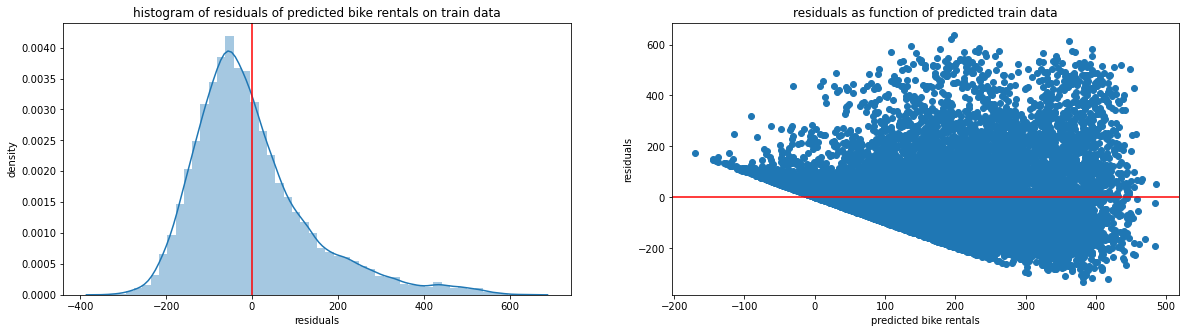

In [144]:
# the code here
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(residuals, ax=ax[0])
ax[0].set_title('histogram of residuals of predicted bike rentals on train data')
ax[0].set_xlabel('residuals')
ax[0].set_ylabel('density')
ax[0].axvline(0, 0, 1, color='r')
ax[1].scatter(sorted_ols_predicted_counts_train, residuals)
ax[1].set_title('residuals as function of predicted train data')
ax[1].set_xlabel('predicted bike rentals')
ax[1].set_ylabel('residuals')
ax[1].axhline(0, 0, 1, color='r')
plt.show()

#### **4.4** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from `X_train` with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

In [145]:
# Create 2nd order polynomial terms
X_train_poly = BSS_train.copy()
X_train_poly["temp_squared"] = X_train_poly.temp ** 2
X_train_poly["hour_squared"] = X_train_poly.hour ** 2
X_train_poly["hum_squared"] = X_train_poly.hum ** 2
X_test_poly = BSS_test.copy()
X_test_poly["temp_squared"] = X_test_poly.temp ** 2
X_test_poly["hour_squared"] = X_test_poly.hour ** 2
X_test_poly["hum_squared"] = X_test_poly.hum ** 2


In [146]:
# prepare predictors
predictors_poly = ['hour', 'holiday', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue',
       'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm', 'temp_squared', 'hour_squared', 'hum_squared']
design_mat_train_poly = X_train_poly[predictors_poly]
design_mat_train_poly = sm.add_constant(design_mat_train_poly)

# fit a multilinear regression model
fitted_model_train_poly = OLS(X_train_poly.counts, design_mat_train_poly, hasconst=True).fit()
fitted_model_train_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     357.5
Date:                Sat, 21 Nov 2020   Prob (F-statistic):               0.00
Time:                        15:09:30   Log-Likelihood:                -87752.
No. Observations:               13903   AIC:                         1.756e+05
Df Residuals:                   13870   BIC:                         1.758e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -170.0037     14.680    -11.581      0.000    -198.778    -141.229
hour            38.4605      0.693     55.497      0.000      37.102      39.819
holiday        -12.6657      6.346     -1.996      0.046     -25.104      -0.227
workingday      12.1305      2.645      4.587      0.000       6.947      17.314
temp           346.6924     60.780      5.704      0.000     227.554     465.830
atemp           12.3483     45.585      0.271      0.786     -77.005     101.702
hum             76.0973     37.796      2.013      0.044       2.013     150.182
windspeed      -24.1249     10.382     -2.324      0.020     -44.475      -3.775
spring          46.3718      7.129      6.504      0.000      32.397      60.346
summer          34.7578      8.452      4.113      0.000      18.191      51.324
fall            70.3279      7.206      9.759      0.000      56.203      84.453
Feb             -4.7651      5.800     -0.822      0.411     -16.134       6.603
Mar             -4.2284      6.593     -0.641      0.521     -17.152       8.695
Apr            -31.2172      9.662     -3.231      0.001     -50.157     -12.278
May            -27.2006     10.233     -2.658      0.008     -47.259      -7.142
Jun            -50.3522     10.367     -4.857      0.000     -70.673     -30.031
Jul            -77.8098     11.676     -6.664      0.000    -100.697     -54.923
Aug            -49.7040     11.466     -4.335      0.000     -72.178     -27.230
Sept           -10.8007     10.341     -1.044      0.296     -31.071       9.470
Oct            -15.4695      9.690     -1.596      0.110     -34.463       3.524
Nov            -27.7146      9.317     -2.975      0.003     -45.976      -9.453
Dec            -14.2818      7.413     -1.927      0.054     -28.812       0.249
Mon             -2.3373      2.862     -0.817      0.414      -7.947       3.273
Tue             -4.1252      3.083     -1.338      0.181     -10.169       1.918
Wed              2.4544      3.059      0.802      0.422      -3.542       8.451
Thu             -0.5991      3.062     -0.196      0.845      -6.600       5.402
Fri              4.0719      3.063      1.329      0.184      -1.932      10.076
Sat             15.3448      4.212      3.643      0.000       7.088      23.602
Cloudy          -5.0215      2.807     -1.789      0.074     -10.523       0.480
Snow           -42.3194      4.800     -8.817      0.000     -51.728     -32.911
Storm           50.5439     94.558      0.535      0.593    -134.802     235.890
temp_squared   -14.1642     38.051     -0.372      0.710     -88.749      60.420
hour_squared    -1.3254      0.028    -47.160      0.000      -1.380      -1.270
hum_squared   -184.9746     30.250     -6.115      0.000    -244.268    -125.681
==============================================================================
Omnibus

**predict bike rentals using the new polynomial model on training set**



In [147]:
def sorted_model(p):
    sorted_X_train_poly = X_train_poly.copy()
    sorted_X_train_poly = sorted_X_train_poly.sort_values([p])
    sorted_design_mat_train_poly = sorted_X_train_poly[predictors_poly]
    sorted_design_mat_train_poly = sm.add_constant(sorted_design_mat_train_poly)
    sorted_fitted_model_train_poly = OLS(sorted_X_train_poly.counts, sorted_design_mat_train_poly, hasconst=True).fit()
    predicted_counts_poly = sorted_fitted_model_train_poly.predict(sorted_design_mat_train_poly)
    return {'observed': sorted_X_train_poly[p], 'predicted': predicted_counts_poly}

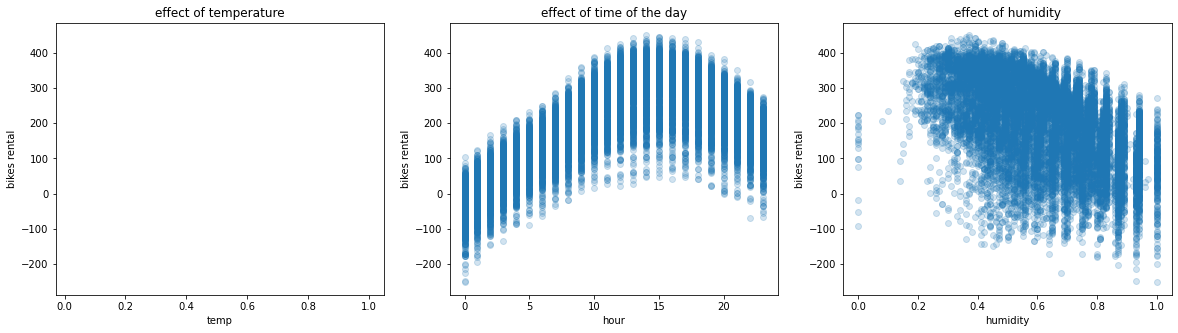

In [148]:
temp_model = sorted_model('temp')
hour_model = sorted_model('hour')
humidity_model = sorted_model('hum')

fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].scatter(temp_model['observed'], temp_model['predicted'], alpha=0.)
ax[0].set_xlabel('temp')
ax[0].set_ylabel('bikes rental')
ax[0].set_title('effect of temperature')

ax[1].scatter(hour_model['observed'], hour_model['predicted'], alpha=0.2)
ax[1].set_xlabel('hour')
ax[1].set_ylabel('bikes rental')
ax[1].set_title('effect of time of the day')

ax[2].set_xlabel('humidity')
ax[2].set_ylabel('bikes rental')
ax[2].set_title('effect of humidity')
ax[2].scatter(humidity_model['observed'], humidity_model['predicted'], alpha=0.2);


#### **4.5** The strange coefficients from 4.2 could also come from _multicolinearity_, where one or more predictors capture the same information as existing predictors. Why can multicolinearity lead to erroneous coefficient values? Create a temporary dataset `X_train_drop` that drops the following 'redundant' predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall`. Fit a multiple linear regression model to `X_train_drop`. Are the estimates more sensible in this model?

In [150]:
design_mat_train_poly_drop = design_mat_train_poly.copy()
design_mat_train_poly_drop = design_mat_train_poly.drop(columns = ['workingday', 'atemp', 'spring', 'summer', 'fall'])
fitted_model_train_poly_clean = OLS(X_train_poly.counts, design_mat_train_poly_drop, hasconst=True).fit()
fitted_model_train_poly_clean.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     400.8
Date:                Sat, 21 Nov 2020   Prob (F-statistic):               0.00
Time:                        15:09:55   Log-Likelihood:                -87813.
No. Observations:               13903   AIC:                         1.757e+05
Df Residuals:                   13874   BIC:                         1.759e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -171.0970     14.675    -11.659      0.000    -199.863    -142.331
hour            38.5168      0.696     55.379      0.000      37.154      39.880
holiday        -30.5131      7.119     -4.286      0.000     -44.468     -16.558
temp           387.9643     38.082     10.188      0.000     313.319     462.609
hum             65.1888     37.321      1.747      0.081      -7.964     138.342
windspeed      -31.3573     10.061     -3.117      0.002     -51.079     -11.636
Feb             -5.7315      5.824     -0.984      0.325     -17.147       5.684
Mar              9.9429      6.145      1.618      0.106      -2.103      21.989
Apr             12.5709      6.656      1.889      0.059      -0.476      25.617
May             15.6356      7.488      2.088      0.037       0.958      30.313
Jun            -11.1305      8.099     -1.374      0.169     -27.006       4.745
Jul            -45.7358      8.816     -5.188      0.000     -63.017     -28.454
Aug            -18.3993      8.364     -2.200      0.028     -34.793      -2.006
Sept            29.7606      7.716      3.857      0.000      14.637      44.884
Oct             51.5769      6.858      7.521      0.000      38.135      65.019
Nov             40.7049      6.128      6.642      0.000      28.692      52.717
Dec             30.1671      5.849      5.157      0.000      18.702      41.632
Mon             10.2991      4.394      2.344      0.019       1.687      18.912
Tue              7.6816      4.271      1.798      0.072      -0.691      16.054
Wed             14.3871      4.246      3.388      0.001       6.064      22.710
Thu             11.5267      4.274      2.697      0.007       3.148      19.905
Fri             15.3557      4.258      3.606      0.000       7.010      23.702
Sat             14.6520      4.229      3.465      0.001       6.363      22.941
Cloudy          -5.0295      2.817     -1.786      0.074     -10.551       0.492
Snow           -43.2187      4.818     -8.970      0.000     -52.663     -33.775
Storm           50.3011     94.959      0.530      0.596    -135.832     236.435
temp_squared   -40.1818     37.482     -1.072      0.284    -113.653      33.289
hour_squared    -1.3271      0.028    -47.046      0.000      -1.382      -1.272
hum_squared   -174.1359     29.892     -5.825      0.000    -232.729    -115.543
==============================================================================
Omnibus:                     3525.953   Durbin-Watson:                   0.800
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8606.649
Skew:                           1.404   Prob(JB):                         0.00
Kurtosis:                       5.640   Cond. No.                     2.05e+04
==============================================================================

Warnings:
[1] St

## Part 5: Subset Selection 


#### **5.1** Implement forward step-wise selection to select a minimal subset of predictors that are related to the response variable. Run the code on the richest dataset, `X_train_poly`, and determine which predictors are selected.

In [151]:
predictors_all = ['hour', 'holiday', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue',
       'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm', 'temp_squared', 'hour_squared', 'hum_squared']



In [152]:
def linear_regression_train(s):
    design_mat_train_poly_subset = X_train_poly[s]
    design_mat_train_poly_subset = sm.add_constant(design_mat_train_poly_subset)
    fitted_model_train_poly_subset = OLS(X_train_poly.counts, design_mat_train_poly_subset).fit()
    return fitted_model_train_poly_subset

def linear_regression_test(s):
    design_mat_test_poly_subset = X_test_poly[s]
    design_mat_test_poly_subset = sm.add_constant(design_mat_test_poly_subset)
    fitted_model_test_poly_subset = OLS(X_test_poly.counts, design_mat_test_poly_subset).fit()
    return fitted_model_test_poly_subset
  
def select_next_predictor(current_predictors, candidate_predictors):
    model = linear_regression_train(current_predictors)
    min_bic = model.bic
    best_predictor = None
    for predictor in candidate_predictors:
        current_predictors_copy = current_predictors.copy()
        current_predictors_copy.append(predictor)
        model = linear_regression_train(current_predictors_copy)
        if model.bic < min_bic:
            best_predictor = predictor
            min_bic = model.bic
    if best_predictor != None:
        current_predictors.append(best_predictor)
        return True
    else:
        return False
    
candidates_predictors = ['holiday', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue',
       'Wed', 'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm', 'temp_squared', 'hour_squared', 'hum_squared']

# forward predictors selection using BIC on train data

selected_predictors = ['hour']
selected_predictors_sets = []
while len(candidates_predictors)>0:
    if select_next_predictor(selected_predictors, candidates_predictors):
        candidates_predictors.remove(selected_predictors[-1])
        selected_predictors_sets.append(selected_predictors.copy())
    else:
        break

# comparison of predictors set and model selection using BIC on test data
model = linear_regression_test(['hour'])
min_bic = model.bic
for predictors_set in selected_predictors_sets:
  model = linear_regression_test(predictors_set)
  if model.bic < min_bic:
      selected_predictors = predictors_set
      min_bic = model.bic

In [153]:
# subsets of predictors which where selected using forward step-wise selection on train data
selected_predictors_sets


[['hour', 'hour_squared'],
 ['hour', 'hour_squared', 'temp'],
 ['hour', 'hour_squared', 'temp', 'hum_squared'],
 ['hour', 'hour_squared', 'temp', 'hum_squared', 'fall'],
 ['hour', 'hour_squared', 'temp', 'hum_squared', 'fall', 'Jul'],
 ['hour', 'hour_squared', 'temp', 'hum_squared', 'fall', 'Jul', 'Snow'],
 ['hour',
  'hour_squared',
  'temp',
  'hum_squared',
  'fall',
  'Jul',
  'Snow',
  'spring'],
 ['hour',
  'hour_squared',
  'temp',
  'hum_squared',
  'fall',
  'Jul',
  'Snow',
  'spring',
  'Sept'],
 ['hour',
  'hour_squared',
  'temp',
  'hum_squared',
  'fall',
  'Jul',
  'Snow',
  'spring',
  'Sept',
  'holiday'],
 ['hour',
  'hour_squared',
  'temp',
  'hum_squared',
  'fall',
  'Jul',
  'Snow',
  'spring',
  'Sept',
  'holiday',
  'Jun']]

In [154]:
# set of predictors which where selected using models comparison (bic) on test data
selected_predictors

['hour',
 'hour_squared',
 'temp',
 'hum_squared',
 'fall',
 'Jul',
 'Snow',
 'spring',
 'Sept',
 'holiday',
 'Jun']

In [155]:
# Standardizing the predictors in order to make them unitless for fairer comparisons: 
X_train_poly_normalized = (X_train_poly-X_train_poly.mean())/X_train_poly.std()
X_test_poly_normalized =(X_test_poly-X_test_poly.mean())/X_test_poly.std()
X_test_poly_normalized.head()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,spring,...,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm,temp_squared,hour_squared,hum_squared
0,-0.813782,-0.165778,-0.988985,-1.495278,-1.447916,-1.192514,0.937306,-1.539471,-1.040171,-0.586125,...,-0.390971,-0.416035,-0.415084,2.471159,-0.601635,-0.288409,-0.016961,-1.221624,-0.897439,0.918437
1,-0.379065,-0.165778,-0.988985,-1.495278,-0.927100,-0.750438,0.729086,-1.539471,-0.975755,-0.586125,...,-0.390971,-0.416035,-0.415084,2.471159,-0.601635,-0.288409,-0.016961,-0.942654,-0.621851,0.656484
2,1.214900,-0.165778,-0.988985,-1.495278,-0.510447,-0.397010,1.301692,0.511925,-0.857660,-0.586125,...,-0.390971,-0.416035,-0.415084,2.471159,1.661659,-0.288409,-0.016961,-0.645087,1.331758,1.409179
3,-0.234159,-0.165778,-0.988985,-1.495278,-0.718774,-0.750438,0.989361,0.270965,-0.766404,-0.586125,...,-0.390971,-0.416035,-0.415084,-0.404552,1.661659,-0.288409,-0.016961,-0.802136,-0.505492,0.986024
4,0.055653,-0.165778,-0.988985,-1.495278,-0.718774,-0.839086,0.208535,0.874174,-0.551684,-0.586125,...,-0.390971,-0.416035,-0.415084,-0.404552,1.661659,-0.288409,-0.016961,-0.802136,-0.236029,0.060373


In [156]:
# fit the best model on train data using the set of predictors which where selected using models comparison (bic) on test data
best_model = linear_regression_train(selected_predictors)
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     1030.
Date:                Sat, 21 Nov 2020   Prob (F-statistic):               0.00
Time:                        15:10:26   Log-Likelihood:                -87786.
No. Observations:               13903   AIC:                         1.756e+05
Df Residuals:                   13891   BIC:                         1.757e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -140.7030      5.361    -26.245      0.000    -151.212    -130.194
hour            38.1747      0.673     56.763      0.000      36.857      39.493
hour_squared    -1.3134      0.027    -47.810      0.000      -1.367      -1.260
temp           332.6262      7.690     43.256      0.000     317.553     347.699
hum_squared   -123.0671      5.483    -22.445      0.000    -133.814    -112.320
fall            55.5861      2.938     18.921      0.000      49.828      61.344
Jul            -32.8398      5.053     -6.500      0.000     -42.743     -22.936
Snow           -43.1307      4.449     -9.695      0.000     -51.851     -34.411
spring          25.8946      3.068      8.441      0.000      19.881      31.908
Sept            26.9924      4.565      5.913      0.000      18.044      35.940
holiday        -25.6510      6.740     -3.806      0.000     -38.863     -12.439
Jun            -15.6397      4.642     -3.369      0.001     -24.738      -6.542
==============================================================================
Omnibus:                     3546.069   Durbin-Watson:                   0.801
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8757.176
Skew:                           1.406   Prob(JB):                         0.00
Kurtosis:                       5.684   Cond. No.                     1.98e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [157]:
print("selected predictors: ", selected_predictors)
print("eliminated predictors: ", set(predictors_all)- set(selected_predictors))
print("R2: ", best_model.rsquared)
print("BIC: ", best_model.bic) 

selected predictors:  ['hour', 'hour_squared', 'temp', 'hum_squared', 'fall', 'Jul', 'Snow', 'spring', 'Sept', 'holiday', 'Jun']
eliminated predictors:  {'Nov', 'Mar', 'Wed', 'Thu', 'Tue', 'Aug', 'Oct', 'Storm', 'summer', 'Sat', 'Cloudy', 'Apr', 'Feb', 'hum', 'atemp', 'Mon', 'workingday', 'Fri', 'windspeed', 'Dec', 'May', 'temp_squared'}
R2:  0.4493269812445593
BIC:  175686.6398322799


#### **5.2** Does forward selection eliminate one or more of the colinear predictors we dropped in Question  4.5 (`workingday` `atemp` `spring` `summer` and `fall`)? If any of the five predictors are not dropped, explain why.

#### **5.3** Fit the linear regression model using the identified subset of predictors to the training set. How do the train and test $R^2$ scores for this fitted step-wise model compare with the train and test $R^2$ scores from the polynomial model fitted in Question 4.4?

In [158]:
# calculare R2 of both polynomial (4.4) model and best model (5.1) on test and train data
def evaluate_model(model, predictors):
    # linear regression using the 'best' model on test data
    design_mat_test_poly = X_test_poly[predictors]
    design_mat_test_poly = sm.add_constant(design_mat_test_poly)
    predicted_counts_test = model.predict(design_mat_test_poly)
    r2_test = r2_score(X_test_poly['counts'], predicted_counts_test)
    # linear regression using the 'best' model on train data
    design_mat_train_poly = X_train_poly[predictors]
    design_mat_train_poly = sm.add_constant(design_mat_train_poly)
    predicted_counts_train = model.predict(design_mat_train_poly)
    r2_train = r2_score(X_train_poly['counts'], predicted_counts_train)
    return (r2_train, r2_test)
  


In [159]:
print ("R2 score for the fitted step-wise model on (train, test) data is: " + str(evaluate_model(best_model, selected_predictors)))


R2 score for the fitted step-wise model on (train, test) data is: (0.4493269812445593, 0.4386824653131699)


In [160]:
print ("R2 score for the 4.4 polynomial model on (train, test) data is: " + str(evaluate_model(fitted_model_train_poly, predictors_poly)))


R2 score for the 4.4 polynomial model on (train, test) data is: (0.4520259183519364, 0.43948913746131435)
